# Geometric Datasets: Exeter

## Description

Code for creating the geometric datasets for the Two-Objective Design/Resilience networks from [Exeter Benchmarks](https://emps.exeter.ac.uk/engineering/research/cws/resources/benchmarks/design-resiliance-pareto-fronts/) 

*Small Problems*
* Two-Reservoir Network
* Two-Loop Network
* BakRyan Network

*Medium Problems*
* New York Tunnel Network
* Blacksburg Network
* Hanoi Network

*Intemediate Problems*
* Fossolo Network
* Pescara Network

*Large Problems*
* Modena Network
* Balerma Irrigation Network

*GoYang Network and Exeter Network were excluded because they had accessories (Pumps and valves) not yet contemplated for the extent of this exercise. 


## Imports

### Basic

In [51]:
import os
import wntr
import pandas as pd
import numpy as np
import pickle
import networkx as nx

#Custom .py file
from PrasadParkIndex import *
from res_index import *

### PyTorch and PyG

In [7]:
import torch
from torch_geometric.data import Data

#from torch_geometric.datasets import TUDataset

C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### DeepSNAP

In [8]:
# from deepsnap.graph import Graph as dSNAP_Graph
# from deepsnap.dataset import GraphDataset as dSNAP_GraphDS

## Loading inp file

In [9]:
# Create a water network model
def load_inp(inp_file_path):
    wn_WDS = wntr.network.WaterNetworkModel(inp_file_path)

    # Plot the network
    wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    return(wn_WDS, sim_WDS, results_WDS)

### Name of the Network 

Choices:
\['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']

In [10]:
name_WDS = 'BLA'

In [11]:
#Read the Network info
WDS_info = pd.read_csv('./networks/Exeter/'+name_WDS+'_info.csv', dtype = {'NodeID': str} )

In [12]:
WDS_info.head()

,D,Cost,NodeID,MinPressure_m,UNITS_TO_M
0,25.4,0.52,1,30,0.001
1,50.8,2.10,2,30,NaN
2,76.2,4.72,3,30,NaN
3,101.6,8.40,4,30,NaN
4,152.4,18.90,5,30,NaN


In [13]:
#Transform the min. pressure of the nodes into a pandas dataframe
min_pres = WDS_info[['NodeID', 'MinPressure_m']].dropna()
min_pres = min_pres.set_index('NodeID')

#Obtain the conversion factor for the diameters (Some are given in inches, meters, or mm)
UNIT_TO_M = WDS_info['UNITS_TO_M'].dropna().item()

### Load the inp file

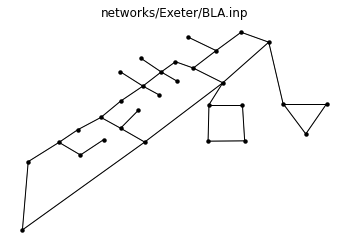

In [14]:
path= 'networks/Exeter/'+name_WDS+'.inp'
wn_WDS, _, _ = load_inp(path)
#wn_WDS = wntr.network.WaterNetworkModel(path)

In [15]:
# a = pd.DataFrame(wn_WDS.node_name_list)
# a.to_clipboard()

In [16]:
names = ['BAK', 'BIN', 'BLA', 'FOS', 'HAN', 'MOD', 'NYT', 'PES', 'TLN', 'TRN']
seeds = [132, 65464, 8754, 465542, 13211, 9874545, 12, 9872, 6781, 978888]
dict_seeds =dict(zip(names, seeds))


In [17]:
num_pipes = wn_WDS.num_pipes

avail_diams = list(WDS_info.D.dropna()) #[6, 8, 10, 12, 14] #inches
pipe_names = wn_WDS.link_name_list

seed = dict_seeds[name_WDS] #Trial seed: 4345
np.random.seed(seed)

N_iter = 5000

In [18]:
avail_diams

[25.4,
 50.8,
 76.2,
 101.6,
 152.4,
 203.2,
 254.0,
 304.8,
 355.6,
 406.4,
 457.2,
 508.0,
 558.8,
 609.6]

## Dataset Creation

In [19]:
node_attributes = ['node_id','node_type','base_demand','elevation','base_head','coords']
edge_attributes = ['link_id','length','diameter','roughness']

In [20]:
def from_wntr_to_pandas(wn):
  # node features and coordinates
  df_nodes = pd.DataFrame(columns=node_attributes)
  for i, node_id in enumerate(wn.nodes):    
    this_node = wn.get_node(node_id)
    if this_node.node_type == 'Junction':
      df_nodes.loc[i,:] = (node_id, 0, this_node.base_demand, this_node.elevation, 0, this_node.coordinates)      
    elif this_node.node_type == 'Reservoir':
      df_nodes.loc[i,:] = (node_id, 1, 0, 0, this_node.base_head, this_node.coordinates)      
    else:
      print('Only Junctions and Reservoirs so far')      
      break
      
  # link features
  df_links = pd.DataFrame(columns=edge_attributes)
  for i, link_id in enumerate(wn.links):    
    this_link = wn.get_link(link_id)
    if this_link.link_type == 'Pipe':
      df_links.loc[i,:] = (link_id, this_link.length, this_link.diameter, this_link.roughness)      
    else:
      print('Only Pipes so far')      
      break

  # edge indexes
  G = wn.get_graph()
  #COO_edges =0  
  COO_edges = np.array(nx.to_scipy_sparse_matrix(G,format='coo').nonzero())

  return df_nodes, df_links, COO_edges



In [21]:
def from_wntr_to_geometric(wn):      
  df_nodes, df_links, COO_edges = from_wntr_to_pandas(wn)   # get pandas dataframes
  
  # create torch data 
  x = torch.tensor(df_nodes[['node_type','base_demand','elevation','base_head']].astype(float).values, dtype=torch.float)
  pos = torch.tensor(df_nodes['coords'], dtype=torch.float)
  edge_index = torch.tensor(COO_edges, dtype=torch.long)
  edge_attr = torch.tensor(df_links[['length','diameter','roughness']].astype(float).values, dtype=torch.float)
  data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr)

  return data, df_nodes, df_links

In [22]:
#data, df_nodes, df_links = from_wntr_to_geometric(wn_WDS)

In [23]:
#results_WDS.node['pressure']

In [24]:
# print(res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini'))

In [25]:
first_DB = []
fail_DB = []

all_geom_data = [] # geometric data

for sim in range(N_iter):
  DB_row = []  # y data
  # echo on screen
  if sim % 50 == 0 or sim == N_iter-1:
    print(f'iter: {sim}')
    #print(flowrate)
  
  # assign diameters    
  new_diams = np.random.choice(avail_diams, num_pipes)
  new_diams = new_diams * UNIT_TO_M
  for i in range(num_pipes):
      c_pipe = wn_WDS.get_link(pipe_names[i])
      c_pipe.diameter = new_diams[i]
  
  # run the simulation
  try:
    # Simulate hydraulics
    sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
    results_WDS = sim_WDS.run_sim()
    
    try:
      flowrate = pd.DataFrame(results_AnyT.link['flowrate']['82']) #FLowrate at the link with the pump
    except Exception as e1:
      flowrate = 0
    
    # get resilience indexes  
    RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
    RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
    #RI_PP = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    #RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    
    DB_row.append(RI_PP)
    DB_row.append(RI_Todini)
    
    first_DB.append(DB_row)
    
    # create Geometric Data 
    data, _, _ = from_wntr_to_geometric(wn_WDS)
    data.res_Todini = torch.tensor(RI_Todini)
    data.res_PP = torch.tensor(RI_PP)
    all_geom_data.append(data)
      
  except Exception as e:
    fail_row = [sim]
    fail_row.append(np.round(new_diams/UNIT_TO_M, 0))
    fail_row.append(wn_WDS)
    fail_row.append(e)
    print(e)
    fail_DB.append(fail_row)
    #wn_WDS.write_inpfile('Failed files/' + 'fail_' + heading+'_'+str(sim)+ '.inp', version=2.2)

iter: 0


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350
iter: 400
iter: 450
iter: 500
iter: 550
iter: 600
iter: 650
iter: 700
iter: 750
iter: 800
iter: 850
iter: 900
iter: 950
iter: 1000
iter: 1050
iter: 1100
iter: 1150
iter: 1200
iter: 1250
iter: 1300
iter: 1350
iter: 1400
iter: 1450
iter: 1500
iter: 1550
iter: 1600
iter: 1650
iter: 1700
iter: 1750
iter: 1800
iter: 1850
iter: 1900
iter: 1950
iter: 2000
iter: 2050
iter: 2100
iter: 2150
iter: 2200
iter: 2250
iter: 2300
iter: 2350
iter: 2400
iter: 2450
iter: 2500
iter: 2550
iter: 2600
iter: 2650
iter: 2700
iter: 2750
iter: 2800
iter: 2850
iter: 2900
iter: 2950
iter: 3000
iter: 3050
iter: 3100
iter: 3150
iter: 3200
iter: 3250
iter: 3300
iter: 3350
iter: 3400
iter: 3450
iter: 3500
iter: 3550
iter: 3600
iter: 3650
iter: 3700
iter: 3750
iter: 3800
iter: 3850
iter: 3900
iter: 3950
iter: 4000
iter: 4050
iter: 4100
iter: 4150
iter: 4200
iter: 4250
iter: 4300
iter: 4350
iter: 4400
iter: 4450
iter: 4500
iter: 4550
iter: 4600
iter: 46

In [59]:
DB_row

[0    0.052351
 dtype: float64,
 0    0.568696
 dtype: float64]

In [60]:
torch.tensor(RI_Todini)

tensor([0.5687], dtype=torch.float64)

In [26]:
print(len(all_geom_data), len(fail_DB))

5000 0


In [27]:
all_geom_data[0].x[0:5]

tensor([[0.0000e+00, 3.2900e-03, 6.5258e+02, 0.0000e+00],
        [0.0000e+00, 3.1900e-03, 6.4984e+02, 0.0000e+00],
        [0.0000e+00, 1.6300e-03, 6.4648e+02, 0.0000e+00],
        [0.0000e+00, 8.7000e-04, 6.5639e+02, 0.0000e+00],
        [0.0000e+00, 3.3800e-03, 6.5273e+02, 0.0000e+00]])

In [23]:
all_geom_data[0].edge_attr[0:5]

tensor([[6.5000e+01, 1.4460e-01, 2.5000e-03],
        [2.6000e+02, 1.4460e-01, 2.5000e-03],
        [1.6400e+02, 5.8180e-01, 2.5000e-03],
        [2.5000e+02, 4.5220e-01, 2.5000e-03],
        [1.0000e+02, 4.5220e-01, 2.5000e-03]])

In [28]:
# folder
dir_path = os.getcwd()+'\{name}_Geom_DB_{num_iter}'.format(name = name_WDS, num_iter = N_iter)
print(dir_path)

C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\BLA_Geom_DB_5000


In [29]:
dataset = {}
dataset['info'] = 'Dataset for graph regression to compute '+name_WDS+' resilience index. Edge_attr = [Length, diameter, roughness] of every pipe, x =[Node type(junction 0, reservoir 1), Base demand (0 for reservoirs), elevation, base head(0 for junctions)]'
dataset['ngraphs'] = len(all_geom_data)
dataset['data'] = all_geom_data

In [30]:
# save
try:
    os.mkdir(dir_path)    
    pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset.p", "wb" ))
except OSError:
    print ("Creation of the directory %s failed" % dir_path)
else:
    print ("Successfully created the directory %s " % dir_path)

Successfully created the directory C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\BLA_Geom_DB_5000 


In [41]:
pickle.dump(dataset,open(f"{dir_path}/{name_WDS}_dataset.p", "wb" ))

In [31]:
prueba = pickle.load(open(r'C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\BIN_Geom_DB_5000\BIN_dataset.p', 'rb'))

In [ ]:
prueba = pickle.load(open(f'{dir_path}/{name_WDS}_dataset.p', 'rb'))

In [36]:
len(prueba['data'])

4998

In [47]:
res = []
for i in range(len(prueba['data'])):
    res.append(prueba['data'][i].res_Todini)

In [52]:
RI_PP_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
RI_Todini_new = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
RI_PP_old = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)
RI_Todini_old = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 30)

In [55]:
RI_Todini_new, RI_PP_old

(0    0.568696
 dtype: float64,
 0    0.052351
 dtype: float64)

In [58]:
np.array(res).max()

-0.6706771259737744

In [54]:
RI_PP_old

0    0.052351
dtype: float64

In [53]:
RI_PP_new

0    0.052351
dtype: float64

In [ ]:
    RI_PP = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'PP')
    RI_Todini = res_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, min_pres, indx = 'Todini')
    
    #RI_PP = PP_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)
    #RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, PMIN_WDS)

In [48]:
res[0:100]

[tensor([-3.4319], dtype=torch.float64),
 tensor([-25.8657], dtype=torch.float64),
 tensor([-10.3895], dtype=torch.float64),
 tensor([-17.6857], dtype=torch.float64),
 tensor([-11.7860], dtype=torch.float64),
 tensor([-27.7821], dtype=torch.float64),
 tensor([-19.3101], dtype=torch.float64),
 tensor([-16.8624], dtype=torch.float64),
 tensor([-4.9324], dtype=torch.float64),
 tensor([-3.0717], dtype=torch.float64),
 tensor([-9.5332], dtype=torch.float64),
 tensor([-6.3338], dtype=torch.float64),
 tensor([-9.9293], dtype=torch.float64),
 tensor([-4.2703], dtype=torch.float64),
 tensor([-4.1880], dtype=torch.float64),
 tensor([-21.0340], dtype=torch.float64),
 tensor([-23.3149], dtype=torch.float64),
 tensor([-3.6466], dtype=torch.float64),
 tensor([-8.1259], dtype=torch.float64),
 tensor([-14.6266], dtype=torch.float64),
 tensor([-17.6442], dtype=torch.float64),
 tensor([-5.8021], dtype=torch.float64),
 tensor([-8.9788], dtype=torch.float64),
 tensor([-11.9491], dtype=torch.float64),
 ten

In [37]:
prueba['data'][4997].edge_attr[:,1] #Diameters

tensor([0.1130, 0.1808, 0.4522, 0.5818, 0.2262, 0.1628, 0.5818, 0.1808, 0.1130,
        0.1266, 0.1266, 0.5818, 0.1130, 0.1446, 0.1266, 0.4522, 0.4522, 0.1808,
        0.1130, 0.2262, 0.1130, 0.2850, 0.1808, 0.1266, 0.1266, 0.1808, 0.1446,
        0.1130, 0.1808, 0.2262, 0.2262, 0.2850, 0.3618, 0.2850, 0.1446, 0.1130,
        0.3618, 0.2262, 0.1628, 0.1130, 0.2262, 0.3618, 0.1266, 0.2262, 0.4522,
        0.1628, 0.1628, 0.5818, 0.3618, 0.4522, 0.1266, 0.1628, 0.3618, 0.1628,
        0.1266, 0.1628, 0.1628, 0.4522, 0.3618, 0.1130, 0.4522, 0.1808, 0.2850,
        0.1628, 0.2262, 0.1446, 0.5818, 0.1628, 0.3618, 0.1266, 0.5818, 0.1628,
        0.1446, 0.1130, 0.1808, 0.1628, 0.2850, 0.1266, 0.3618, 0.3618, 0.2262,
        0.2850, 0.1628, 0.5818, 0.2850, 0.4522, 0.1130, 0.1266, 0.4522, 0.2850,
        0.2850, 0.1446, 0.2850, 0.1808, 0.5818, 0.1266, 0.3618, 0.5818, 0.2850,
        0.1130, 0.3618, 0.1808, 0.1130, 0.5818, 0.1628, 0.5818, 0.2850, 0.3618,
        0.1130, 0.2850, 0.1266, 0.1628, 

In [34]:
prueba['data'][0].edge_attr[:,1]/ UNIT_TO_M #Diameters

tensor([144.6000, 144.6000, 581.7999, 452.2000, 452.2000, 126.6000, 581.7999,
        126.6000, 180.8000, 361.8000, 226.2000, 144.6000, 361.8000, 285.0000,
        180.8000, 180.8000, 144.6000, 113.0000, 126.6000, 361.8000, 285.0000,
        113.0000, 285.0000, 126.6000, 144.6000, 126.6000, 162.8000, 285.0000,
        452.2000, 452.2000, 162.8000, 113.0000, 162.8000, 113.0000, 162.8000,
        162.8000, 144.6000, 180.8000, 285.0000, 285.0000, 144.6000, 180.8000,
        226.2000, 226.2000, 180.8000, 452.2000, 285.0000, 180.8000, 452.2000,
        581.7999, 126.6000, 144.6000, 581.7999, 144.6000, 162.8000, 285.0000,
        162.8000, 361.8000, 581.7999, 126.6000, 581.7999, 113.0000, 126.6000,
        581.7999, 144.6000, 452.2000, 113.0000, 113.0000, 180.8000, 180.8000,
        226.2000, 226.2000, 361.8000, 126.6000, 180.8000, 452.2000, 113.0000,
        113.0000, 226.2000, 581.7999, 144.6000, 126.6000, 144.6000, 581.7999,
        581.7999, 113.0000, 144.6000, 162.8000, 144.6000, 144.60